# Example processing pipeline with MRtrix3 and Anima
This pipeline illustrates a minimal image processing pipeline using Anima and MRTrix3 on data from the [HCP Young Adult open database](https://www.humanconnectome.org/study/hcp-young-adult). 

## Downloading images from HCP database (on AWS)
<div class="alert alert-block alert-info">
<b>Tip:</b> Make sure you have configured your AWS access to the HCP Young Adult database; for more information, visit <a href="https://wiki.humanconnectome.org/docs/How%20To%20Connect%20to%20Connectome%20Data%20via%20AWS.html">documentation page</a> on the HCP website.
</div>

We will start by downloading diffusion data from an HCP subject, for this you will need to install `boto3` (and `Anima-Tools`, of course).

In [2]:
subject_id = "100206"
!animatools_download_hcp -s {subject_id} -o .

File ./100206/T1w/Diffusion/bvals already exists, skipping...
File ./100206/T1w/Diffusion/bvecs already exists, skipping...
File ./100206/T1w/Diffusion/data.nii.gz already exists, skipping...
File ./100206/T1w/Diffusion/nodif_brain_mask.nii.gz already exists, skipping...
0 files downloaded for subject 100206.
Done!


## Processing data with MRtrix3
We will now perform multishell multi-tissue spherical deconvolution with MRTrix. The first step is to estimate responses for white matter, gray matter and cerebrospinal fluid.

In [3]:
import os, subprocess, sys
path = f"{subject_id}/T1w/Diffusion/"

command = ["dwi2response", "dhollander", 
  os.path.join(path, "data.nii.gz"),
  os.path.join(path, "wm_response.txt"),
  os.path.join(path, "gm_response.txt"),
  os.path.join(path, "csf_response.txt"),
  "-fslgrad", os.path.join(path, "bvecs"), os.path.join(path, "bvals"),
  "-m", os.path.join(path, "nodif_brain_mask.nii.gz"),
  "-force"
]
print(f"Executing command '{subprocess.list2cmdline(command)}'")
subprocess.call(command);

Executing command 'dwi2response dhollander 100206/T1w/Diffusion/data.nii.gz 100206/T1w/Diffusion/wm_response.txt 100206/T1w/Diffusion/gm_response.txt 100206/T1w/Diffusion/csf_response.txt -fslgrad 100206/T1w/Diffusion/bvecs 100206/T1w/Diffusion/bvals -m 100206/T1w/Diffusion/nodif_brain_mask.nii.gz -force'


dwi2response: 
dwi2response: Note that this script makes use of commands / algorithms that have relevant articles for citation. Please consult the help page (-help option) for more information.
dwi2response: 
dwi2response: [WARNING] Output file '100206/T1w/Diffusion/wm_response.txt' already exists; will be overwritten at script completion
dwi2response: [WARNING] Output file '100206/T1w/Diffusion/gm_response.txt' already exists; will be overwritten at script completion
dwi2response: [WARNING] Output file '100206/T1w/Diffusion/csf_response.txt' already exists; will be overwritten at script completion
dwi2response: Generated scratch directory: /home/ecaruyer/local/src/Anima-Tools/examples/dwi2response-tmp-9TDMFC/
dwi2response: Importing DWI data (/home/ecaruyer/local/src/Anima-Tools/examples/100206/T1w/Diffusion/data.nii.gz)...
dwi2response: Importing mask (/home/ecaruyer/local/src/Anima-Tools/examples/100206/T1w/Diffusion/nodif_brain_mask.nii.gz)...
dwi2response: Changing to scratch dire

The next step is to compute spherical deconvolution.

In [4]:
command = ["dwi2fod", "msmt_csd", 
  os.path.join(path, "data.nii.gz"),
  os.path.join(path, "wm_response.txt"), os.path.join(path, "wmfod.nii.gz"),
  os.path.join(path, "gm_response.txt"), os.path.join(path, "gm.nii.gz"),
  os.path.join(path, "csf_response.txt"), os.path.join(path, "csf.nii.gz"),
  "-fslgrad", os.path.join(path, "bvecs"), os.path.join(path, "bvals"),
  "-m", os.path.join(path, "nodif_brain_mask.nii.gz"),
  "-force"
]
print(f"Executing command '{subprocess.list2cmdline(command)}'")
subprocess.call(command);

Executing command 'dwi2fod msmt_csd 100206/T1w/Diffusion/data.nii.gz 100206/T1w/Diffusion/wm_response.txt 100206/T1w/Diffusion/wmfod.nii.gz 100206/T1w/Diffusion/gm_response.txt 100206/T1w/Diffusion/gm.nii.gz 100206/T1w/Diffusion/csf_response.txt 100206/T1w/Diffusion/csf.nii.gz -fslgrad 100206/T1w/Diffusion/bvecs 100206/T1w/Diffusion/bvals -m 100206/T1w/Diffusion/nodif_brain_mask.nii.gz -force'


dwi2fod: [WARNING] existing output files will be overwritten
dwi2fod: uncompressing image "100206/T1w/Diffusion/nodif_brain_mask.nii.gz"... [==================================================]
dwi2fod: uncompressing image "100206/T1w/Diffusion/data.nii.gz"... [==================================================]
dwi2fod: preloading data for "100206/T1w/Diffusion/data.nii.gz"... [==================================================]
dwi2fod: performing MSMT CSD (4 shells, 3 tissues)... [==================================================]
dwi2fod: compressing image "100206/T1w/Diffusion/wmfod.nii.gz"... [==================================================]
dwi2fod: compressing image "100206/T1w/Diffusion/gm.nii.gz"... [==================================================]
dwi2fod: compressing image "100206/T1w/Diffusion/csf.nii.gz"... [==================================================]


Last, we visualize the results.

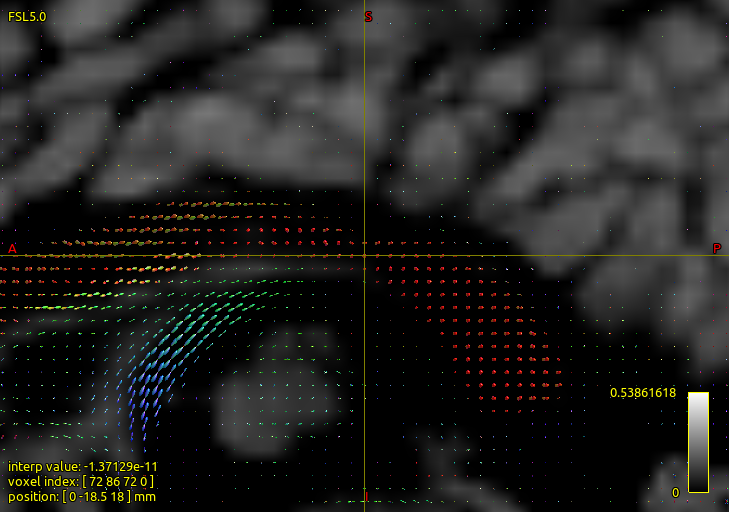

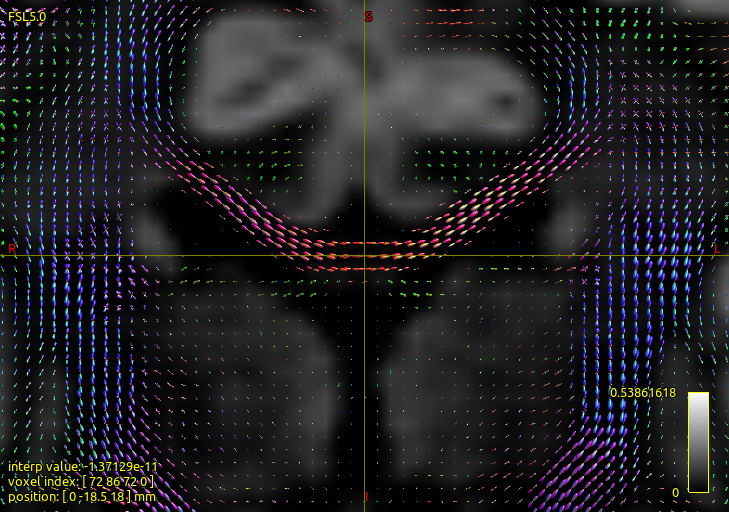

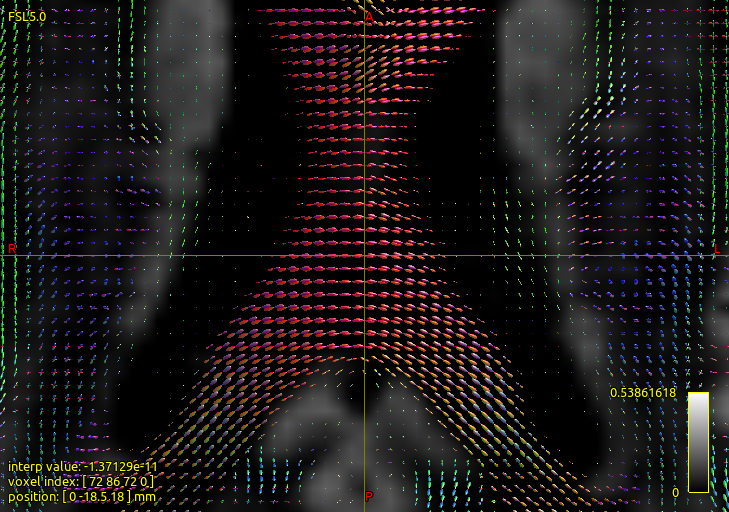

In [5]:
from IPython.display import Image, display
planes = {0: "sagital", 1: "coronal", 2: "axial"}
for plane_id, plane in planes.items():
    command = ["mrview", os.path.join(path, "gm.nii.gz"),
      "-odf.load_sh", os.path.join(path, "wmfod.nii.gz"),
      "-fov", "60.0",
      "-plane", f"{plane_id}", 
      "-capture.folder", path, 
      "-capture.prefix", f"fod_{plane}_",
      "-capture.grab",
      "-exit"
    ]
    subprocess.call(command)
    
    im = Image(filename=os.path.join(path, f"fod_{plane}_0000.png"), width=300)
    display(im)

## Processing data with Anima
We will now perform ODF estimation as implemented in [[Aganj _et al._, 2010]](https://doi.org/10.1002/mrm.22365) using Anima. As the screenshots above suggest, the `bvec` file is well formatted and interpreted properly with MRtrix3. Note that Anima requires a modified `bvec` (voxel coordinates convention in FSL versus real-world LPS convention in Anima).  

In [6]:
command = ["animatools_convert_bvecs",
    "-i", os.path.join(path, "bvecs"),
    "-o", os.path.join(path, "bvecs_anima"),
    "-r", os.path.join(path, "data.nii.gz")]
print(f"Executing command '{subprocess.list2cmdline(command)}'")
subprocess.call(command);

Executing command 'animatools_convert_bvecs -i 100206/T1w/Diffusion/bvecs -o 100206/T1w/Diffusion/bvecs_anima -r 100206/T1w/Diffusion/data.nii.gz'


Let's now compute the ODF.

In [ ]:
# TODO
command = []